In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [263]:
import seaborn as sns
sns.set()

In [3]:
import sys

sys.path.append('C:\\Users\\xsyso\\xgboost\\python-package')
sys.path.append('C:\\Users\\xsyso\\graphviz\\release')
import xgboost as xgb

C:\Users\xsyso\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


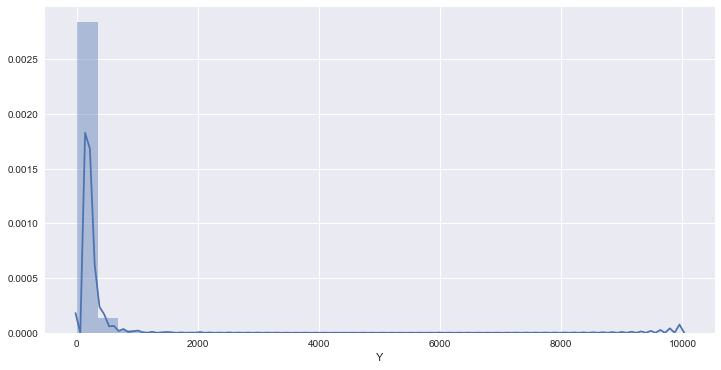

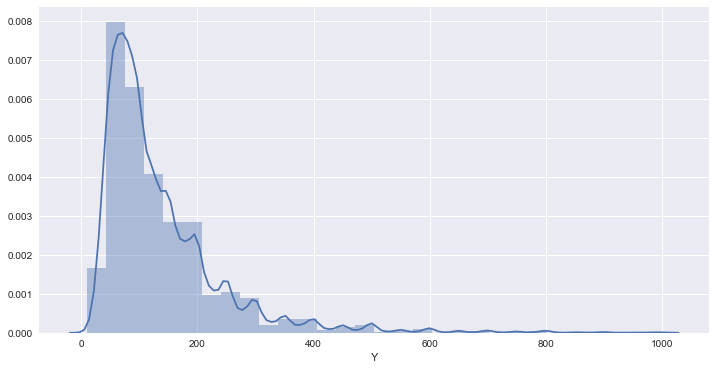

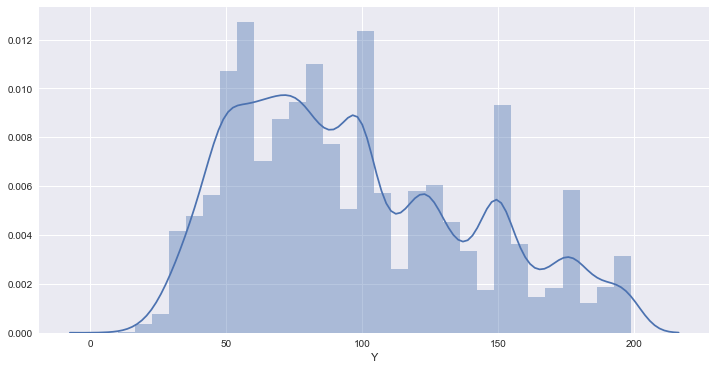

In [315]:
data_plot = pd.read_csv('./airbnb_v2.csv', low_memory=False, index_col=0)
plt.figure(figsize=(12,6))
sns.distplot(data_plot['Y'], bins=30)
plt.show()

plt.figure(figsize=(12,6))
sns.distplot(data_plot['Y'][data_plot['Y']<1000], bins=30)
plt.show()

plt.figure(figsize=(12,6))
sns.distplot(data_plot['Y'][data_plot['Y']<200], bins=30)
plt.show()

In [220]:
data = pd.read_csv('./airbnb_v2.csv', low_memory=False, index_col=0)
data = data[data['Y'] <= 200]
data = data.dropna()
x = data.iloc[:, :-1]
y = data.iloc[:, -1]
x.shape

(30309, 88)

In [221]:
#x = x.as_matrix()
#y = y.as_matrix()

In [243]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

In [244]:
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, colsample_bylevel=0.9, colsample_bytree=0.5)
model.fit(x_train, y_train)

y_pred_valid = model.predict(x_valid)
y_pred_train = model.predict(x_train)

print ("Train Median Absolute Error", metrics.median_absolute_error(y_pred_train, y_train))
print ("Train Mean Absolute Error", metrics.mean_absolute_error(y_pred_train, y_train))
print ("Train Mean Squared Error", metrics.mean_squared_error(y_pred_train, y_train))
print ("Valid Median Absolute Error", metrics.median_absolute_error(y_pred_valid, y_valid))
print ("Valid Mean Absolute Error", metrics.mean_absolute_error(y_pred_valid, y_valid))
print ("Valid Mean Squared Error", metrics.mean_squared_error(y_pred_valid, y_valid))

Train Median Absolute Error 12.9357948303
Train Mean Absolute Error 16.4480550538
Train Mean Squared Error 476.918617731
Valid Median Absolute Error 16.6297855377
Valid Mean Absolute Error 21.3751541883
Valid Mean Squared Error 797.688302671


In [245]:
import operator
importance = model.booster().get_score()
sorted_importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
important_features = [item[0] for item in sorted_importance]

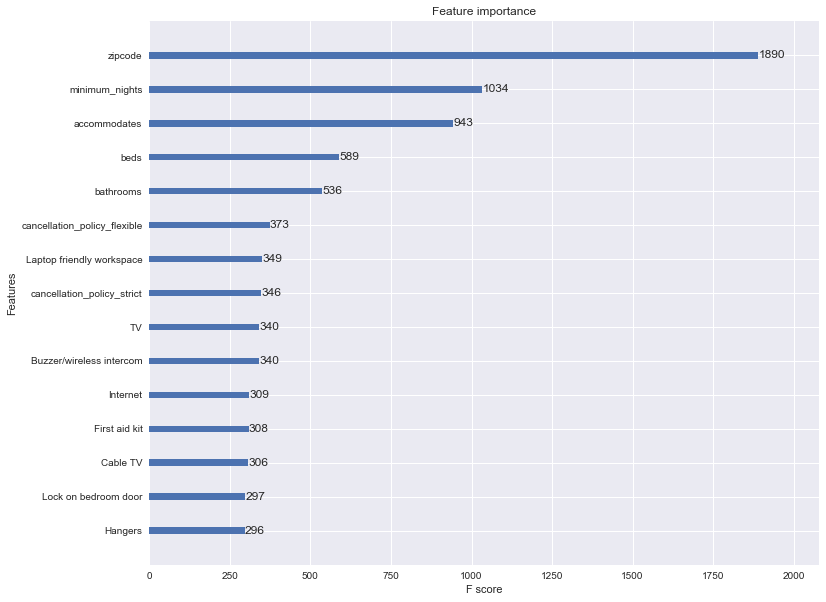

In [289]:
f, ax = plt.subplots(figsize=(12, 10))
#plt.figure(figsize=(13,20))
xgb.plot_importance(model, ax=ax, max_num_features=15)
plt.show()

In [16]:
#xgb.plot_tree(model)
#plt.show()

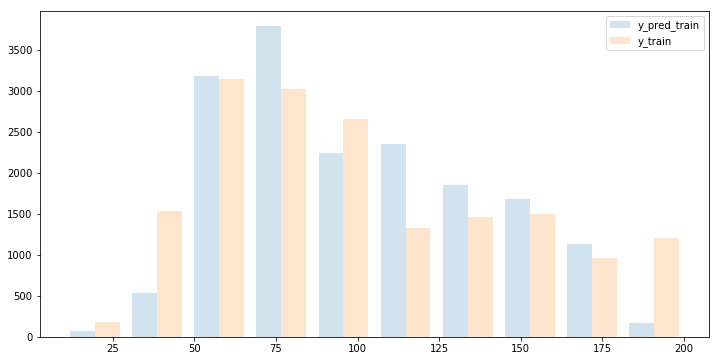

In [253]:
plt.figure(figsize=(12,6))
y_train_plot = np.vstack([y_pred_train, y_train]).T
plt.hist(y_train_plot, alpha=0.2, label=['y_pred_train', 'y_train'])
plt.legend(loc='best')
plt.show()

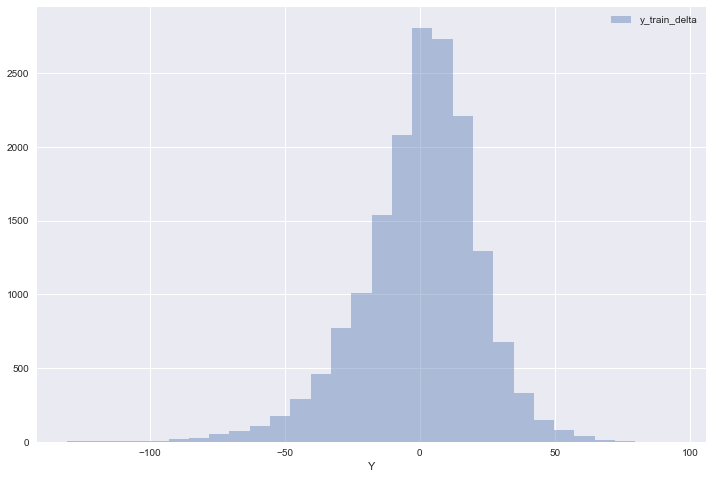

In [304]:
plt.figure(figsize=(12,8))
sns.distplot(y_pred_train - y_train, bins=30, label='y_train_delta', kde=False)
plt.legend(loc='best')
plt.show()

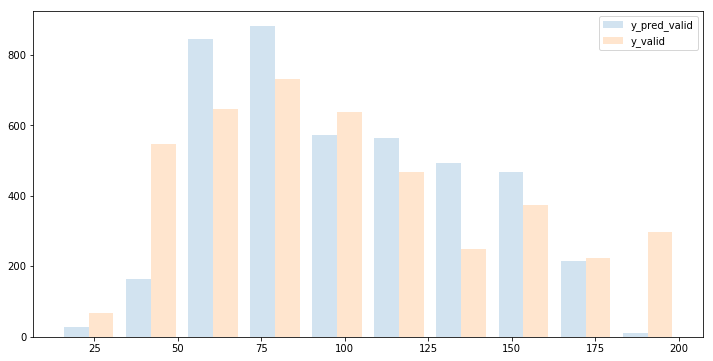

In [257]:
plt.figure(figsize=(12,6))
y_valid_plot = np.vstack([y_pred_valid, y_valid]).T
plt.hist(y_valid_plot, alpha=0.2, label=['y_pred_valid', 'y_valid'])
plt.legend(loc='best')
plt.show()

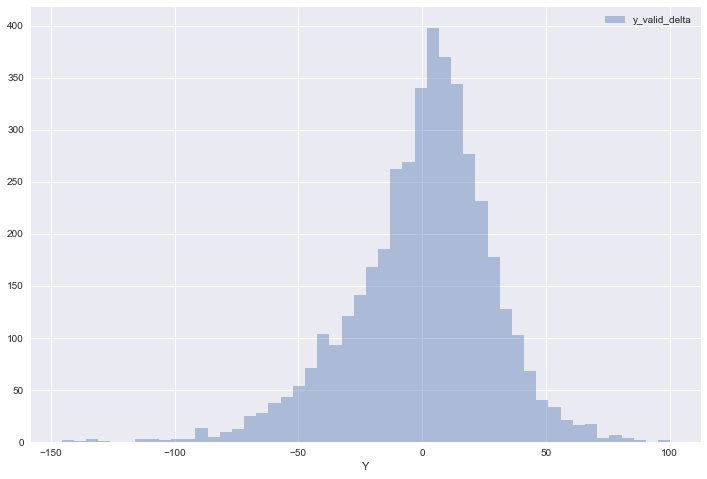

In [316]:
plt.figure(figsize=(12,8))
sns.distplot((y_pred_valid - y_valid), bins=50, label='y_valid_delta', kde=False)
plt.legend(loc='best')
plt.show()

# Error Analysis

In [153]:
y_pred_valid = model.predict(x_valid)
y_pred_train = model.predict(x_train)

print ("Train Median Absolute Error", metrics.median_absolute_error(y_pred_train, y_train))
print ("valid Median Absolute Error", metrics.median_absolute_error(y_pred_valid, y_valid))
print ("valid Mean Absolute Error", metrics.mean_absolute_error(y_pred_valid, y_valid))

Train Median Absolute Error 13.2046585083
valid Median Absolute Error 16.7406997681
valid Mean Absolute Error 21.3080775646


In [154]:
anomalies = np.abs(y_pred_valid - y_valid) > 70
anomalies = anomalies.as_matrix()

In [155]:
len(y_valid[anomalies])

104

In [156]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [157]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(preprocessing.scale(x_valid))

In [158]:
x_pca.shape

(4244, 2)

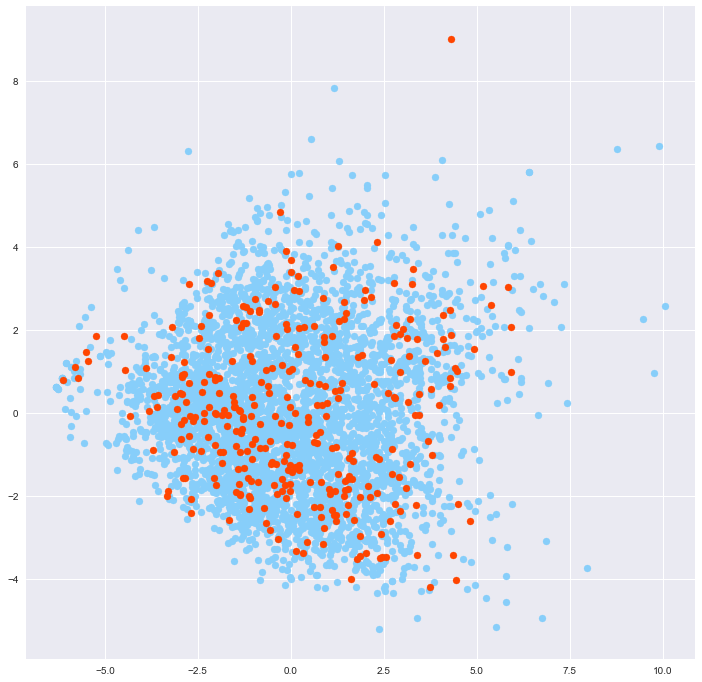

In [313]:
plt.figure(figsize=(12,12))
plt.scatter(x_pca[~anomalies,0], x_pca[~anomalies,1], color='lightskyblue')
plt.scatter(x_pca[anomalies,0], x_pca[anomalies,1], color='orangered')
plt.show()

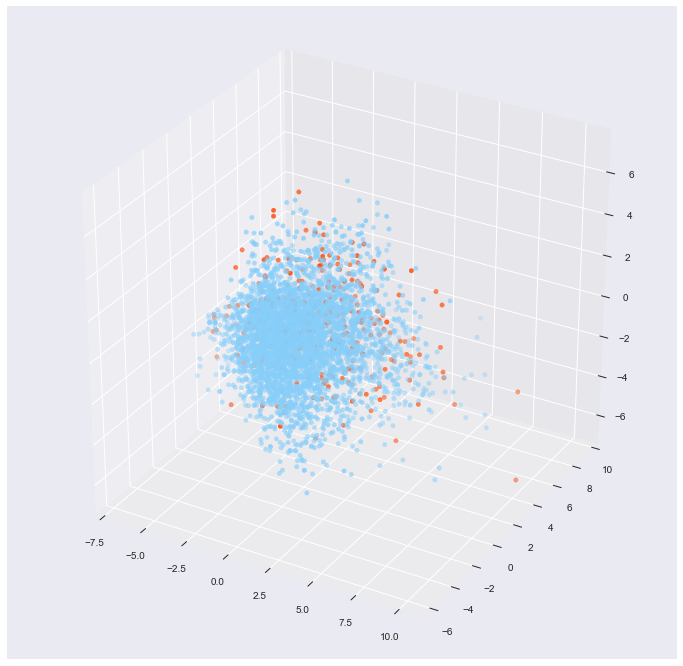

In [318]:
pca3 = PCA(n_components=3)
x_pca3 = pca3.fit_transform(preprocessing.scale(x_valid))

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_pca3[~anomalies,0], x_pca3[~anomalies,1], x_pca3[~anomalies,2], color='lightskyblue')
ax.scatter(x_pca3[anomalies,0], x_pca3[anomalies,1], x_pca3[anomalies,2], color='orangered')
plt.show()

In [160]:
from sklearn.manifold import TSNE

In [161]:
tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(x_valid)

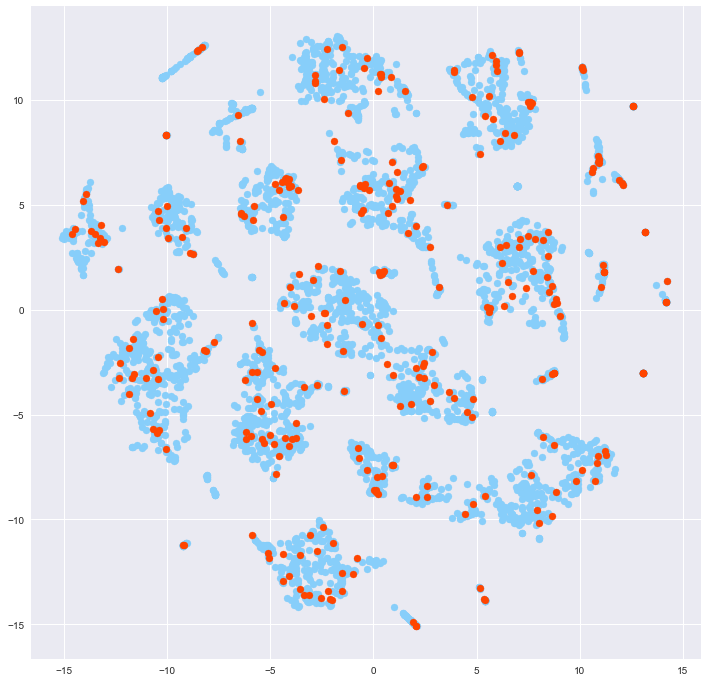

In [314]:
plt.figure(figsize=(12,12))
plt.scatter(x_tsne[~anomalies,0], x_tsne[~anomalies,1], color='lightskyblue')
plt.scatter(x_tsne[anomalies,0], x_tsne[anomalies,1], color='orangered')
plt.show()

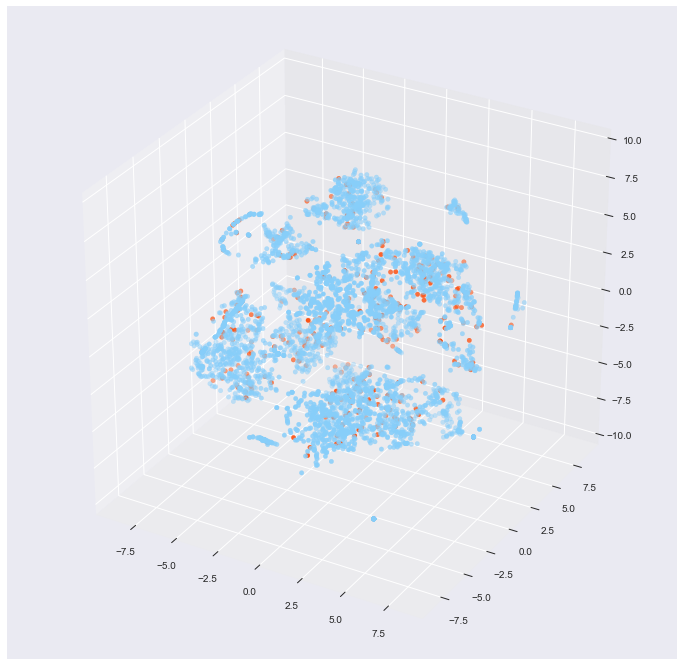

In [319]:
tsne3 = TSNE(n_components=3)
x_tsne3 = tsne3.fit_transform(x_valid)

fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_tsne3[~anomalies,0], x_tsne3[~anomalies,1], x_tsne3[~anomalies,2], color='lightskyblue')
ax.scatter(x_tsne3[anomalies,0], x_tsne3[anomalies,1], x_tsne3[anomalies,2], color='orangered')
plt.show()

In [164]:
df_anomaliles = pd.DataFrame(x_valid[anomalies], columns=data.columns[:-1])

In [165]:
df_anomaliles.iloc[:, :].mean() / data.iloc[:, :-1].mean()

zipcode                                       0.986637
accommodates                                  1.081674
bathrooms                                     0.952697
bedrooms                                      0.990916
beds                                          1.051471
minimum_nights                                0.779567
property_type_Apartment                       0.960902
property_type_Bed & Breakfast                 4.019761
property_type_Boat                            0.000000
property_type_Boutique hotel                  0.000000
property_type_Bungalow                        0.000000
property_type_Cabin                           0.000000
property_type_Camper/RV                       0.000000
property_type_Castle                          0.000000
property_type_Cave                            0.000000
property_type_Chalet                          0.000000
property_type_Condominium                     1.306873
property_type_Dorm                            0.000000
property_t

In [169]:
data.columns[:-1][df_anomaliles.iloc[:, :].mean() / data.iloc[:, :-1].mean() > 3]

Index(['property_type_Bed & Breakfast', 'property_type_Other', 'Pool'], dtype='object')

In [170]:
data.columns[:-1][df_anomaliles.iloc[:, :].mean() / data.iloc[:, :-1].mean() < 1/3]

Index(['property_type_Boat', 'property_type_Boutique hotel',
       'property_type_Bungalow', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Castle', 'property_type_Cave',
       'property_type_Chalet', 'property_type_Dorm',
       'property_type_Guesthouse', 'property_type_Hut', 'property_type_Island',
       'property_type_Serviced apartment', 'property_type_Villa',
       'cancellation_policy_long_term', 'cancellation_policy_no_refunds',
       'cancellation_policy_super_strict_30', 'Self Check-In', 'Keypad',
       'Lockbox', 'Other pet(s)', 'Free parking on street', 'Doorman Entry',
       'Washer / Dryer'],
      dtype='object')

In [169]:
x_valid.sum(axis=0)[6:30], data.columns[6:30]

(array([  2.07400000e+03,   6.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.30000000e+01,   1.00000000e+00,
          6.00000000e+00,   0.00000000e+00,   2.08000000e+02,
          0.00000000e+00,   0.00000000e+00,   4.80000000e+01,
          1.50000000e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.30000000e+01,   1.00000000e+00]),
 Index(['property_type_Apartment', 'property_type_Bed & Breakfast',
        'property_type_Boat', 'property_type_Boutique hotel',
        'property_type_Bungalow', 'property_type_Cabin',
        'property_type_Camper/RV', 'property_type_Castle', 'property_type_Cave',
        'property_type_Chalet', 'property_type_Condominium',
        'property_type_Dorm', 'property_type_Guesthouse',
        'property_type_Hostel', 'property_type_House', 'property_type_Hut',
        'property_type_Island', 'proper

In [174]:
x_valid_freq = x_valid[~((x_valid.iloc[:, 6]==1) )]
y_valid_freq = y_valid[~((x_valid.iloc[:, 6]==1) )]
x_valid.shape, x_valid_freq.shape

((4244, 88), (569, 88))

In [175]:
y_pred_valid_freq = model.predict(x_valid_freq)

print ("valid Median Absolute Error", metrics.median_absolute_error(y_pred_valid_freq, y_valid_freq))
print ("valid Mean Absolute Error", metrics.mean_absolute_error(y_pred_valid_freq, y_valid_freq))

valid Median Absolute Error 14.6662216187
valid Mean Absolute Error 20.0335176129


In [178]:
x_valid_high = x_valid[y_valid > 190]
y_valid_high = y_valid[y_valid > 190]
print(x_valid.shape, x_valid_high.shape)

y_pred_valid_high = model.predict(x_valid_high)

print ("valid Median Absolute Error", metrics.median_absolute_error(y_pred_valid_high, y_valid_high))
print ("valid Mean Absolute Error", metrics.mean_absolute_error(y_pred_valid_high, y_valid_high))

(4244, 88) (235, 88)
valid Median Absolute Error 43.8728027344
valid Mean Absolute Error 50.3645620143


In [181]:
x_valid_low = x_valid[y_valid < 20]
y_valid_low = y_valid[y_valid < 20]
print(x_valid.shape, x_valid_low.shape)

y_pred_valid_low = model.predict(x_valid_low)

print ("valid Median Absolute Error", metrics.median_absolute_error(y_pred_valid_low, y_valid_low))
print ("valid Mean Absolute Error", metrics.mean_absolute_error(y_pred_valid_low, y_valid_low))

(4244, 88) (4, 88)
valid Median Absolute Error 31.3761253357
valid Mean Absolute Error 44.8715748787


In [324]:
bins = 10
loss_hist = np.zeros(bins)
for i in range(bins):
    low, high = i*200/bins, (i+1)*200/bins
    x_valid_hist = x_valid[(y_valid > low) & (y_valid <= high)]
    y_valid_hist = y_valid[(y_valid > low) & (y_valid <= high)]
    if len(x_valid_hist) == 0:
        continue
    y_pred_valid_hist = model.predict(x_valid_hist)
    loss_hist[i] = metrics.median_absolute_error(y_pred_valid_hist, y_valid_hist)
    #plt.hist(y_pred_valid_hist - y_valid_hist)
    #plt.show()
    print ("valid Median Absolute Error", metrics.median_absolute_error(y_pred_valid_hist, y_valid_hist))
    #print ("valid Mean Absolute Error", metrics.mean_absolute_error(y_pred_valid_hist, y_valid_hist))

valid Median Absolute Error 13.2332420349
valid Median Absolute Error 19.3581008911
valid Median Absolute Error 13.4328994751
valid Median Absolute Error 10.3832550049
valid Median Absolute Error 16.6828384399
valid Median Absolute Error 18.109588623
valid Median Absolute Error 17.6119766235
valid Median Absolute Error 17.2716445923
valid Median Absolute Error 26.1041946411
valid Median Absolute Error 42.6254577637


In [331]:
loss_hist

array([ 13.23324203,  19.35810089,  13.43289948,  10.383255  ,
        16.68283844,  18.10958862,  17.61197662,  17.27164459,
        26.10419464,  42.62545776])

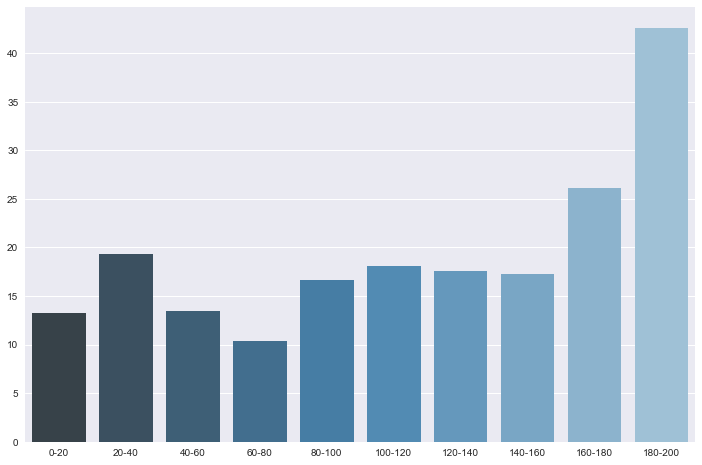

In [356]:
f, ax = plt.subplots()
f.set_size_inches(12,8)
sns.barplot(x=np.arange(0,200,20), y=loss_hist, palette='Blues_d')
ax.set_xticklabels([str(left) + '-' + str(left+20) for left in np.arange(0,200,20)])
plt.show()

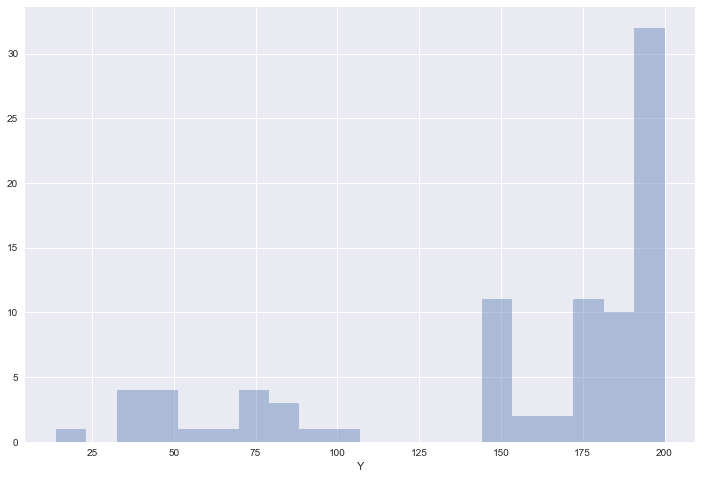

In [321]:
anomalies = np.abs(y_pred_valid - y_valid) > 70
anomalies = anomalies.as_matrix()

plt.figure(figsize=(12,8))
sns.distplot(y_valid[anomalies], bins=20, kde=False)
plt.show()

In [360]:
sum(anomalies * np.ones(len(anomalies)))

88.0